<a href="https://colab.research.google.com/github/hallofaisal/prediksi/blob/main/campak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/gdrive
   tahun  jumlah_kasus
3   2021           239
4   2022          2018
5   2023          8368
6   2024          3682


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


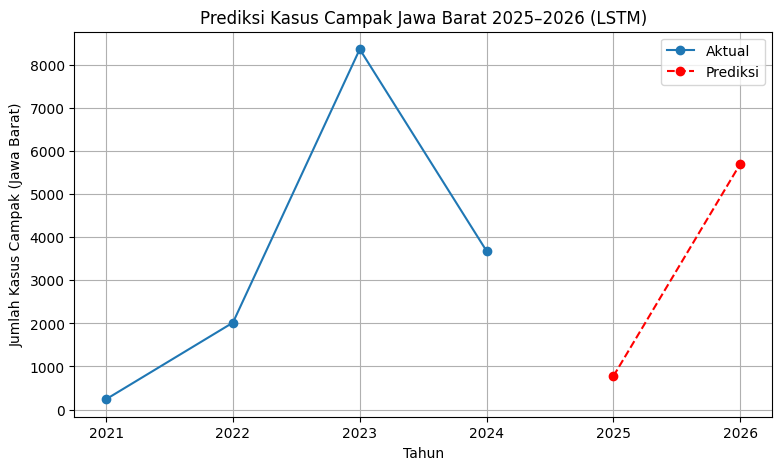

Prediksi 2025: 774 kasus
Prediksi 2026: 5702 kasus


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv(
    '/content/gdrive/My Drive/Colab Notebooks/data/dinkes-od_18508_jml_kasus_penyakit_campak_brdsrkn_kabupatenkota_v1_data.csv'
)

df.columns = df.columns.str.lower()

df_jabar = df[df['kode_provinsi'] == 32]

df_jabar['jumlah_kasus'] = pd.to_numeric(df_jabar['jumlah_kasus'], errors='coerce')

yearly = (
    df_jabar
    .groupby('tahun')['jumlah_kasus']
    .sum()
    .reset_index()
)

yearly = yearly[yearly['tahun'] >= 2021]
years_actual = yearly['tahun'].values
cases_actual = yearly['jumlah_kasus'].values.reshape(-1, 1)

print(yearly)

scaler = MinMaxScaler()
cases_scaled = scaler.fit_transform(cases_actual)

def create_sequences(data, window=2):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 2
X, y = create_sequences(cases_scaled, window)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential([
    LSTM(32, activation='tanh', input_shape=(window, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=300, batch_size=1, verbose=0)

current = cases_scaled[-window:]
future_scaled = []

for _ in range(2):
    pred = model.predict(current.reshape(1, -1, 1), verbose=0)
    future_scaled.append(pred[0,0])
    current = np.append(current[1:], pred)

future = scaler.inverse_transform(
    np.array(future_scaled).reshape(-1, 1)
)

years_future = np.array([2025, 2026])

plt.figure(figsize=(9,5))
plt.plot(years_actual, cases_actual.flatten(), marker='o', label='Aktual')
plt.plot(years_future, future.flatten(), marker='o',
         linestyle='--', color='red', label='Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Kasus Campak (Jawa Barat)')
plt.title('Prediksi Kasus Campak Jawa Barat 2025–2026 (LSTM)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Prediksi 2025: {int(future[0][0])} kasus")
print(f"Prediksi 2026: {int(future[1][0])} kasus")
